In [16]:
import importlib
import ddqn
import gan
import torch
import numpy as np
importlib.reload(ddqn)
importlib.reload(gan)
from ddqn import SimpleEstimator, train_ddqn_and_gan, Trajectory, Conv1dEstimator
from gan import GAN1d
import gym
import matplotlib.pyplot as plt
import copy

## First, Initialize the gym, dqn as a "Simple Estimator", and gan

In [2]:
env = gym.make("Pong-ram-v0")
small_obs_buffer = 4
action_dim = env.action_space.n
obs_dim = env.observation_space.shape[0] * small_obs_buffer
hidden_dim = 4000
discriminator_hidden_dim = 1500
VALID_ACTIONS = [i for i in range(action_dim)]
out_channels = 64
kernel_size = 8

/anaconda3/envs/deeprlbootcamp/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [17]:
env = gym.make("LunarLander-v2")
small_obs_buffer = 4
action_dim = env.action_space.n
obs_dim = env.observation_space.shape[0] * small_obs_buffer
hidden_dim = 4000
discriminator_hidden_dim = 1500
VALID_ACTIONS = [i for i in range(action_dim)]
out_channels = 64
kernel_size = 2

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [18]:
# env = gym.make("CartPole-v1")
# small_obs_buffer = 2
# action_dim = env.action_space.n
# obs_dim = env.observation_space.shape[0] * small_obs_buffer
# hidden_dim = 100
# discriminator_hidden_dim = 40
# VALID_ACTIONS = [i for i in range(action_dim)]
# out_channels = 32
# kernel_size = 1

In [19]:
# env = gym.make("CartPole-v1")
# env = gym.make("LunarLander-v2")
# VALID_ACTIONS = [0,1,2,3]
# action_dim = 4
# obs_dim = 8
# hidden_dim = 600
# # discriminator_hidden_dim = 400
# kernel_size=2
#q_est = SimpleEstimator(action_dim, obs_dim, hidden_dim)
# Change the buffer situation
q_est = Conv1dEstimator(action_dim, obs_dim, hidden_dim, small_obs_buffer, out_channels, kernel_size)
#q_est = SimpleEstimator(action_dim, obs_dim, hidden_dim)
gan_latent = 16
eric_gan = GAN1d(gan_latent, obs_dim, discriminator_hidden_dim)
q_target = copy.deepcopy(q_est)
for p in q_target.parameters():
    p.requires_grad = False
optimizer = torch.optim.Adam(q_est.parameters(), lr=0.001)
ddqn_losses, generator_losses, discriminator_losses, rewards_tracking = ([], [], [], [])

## This is the training loop
It returns ddqn loss, generator loss, the squared error for in domain and out of domain (Train for more than 1000000 iterations I think.) This is also really vulnerable to initialization, which makes it challenging to train reliably

In [ ]:
q_target = copy.deepcopy(q_est)
for p in q_target.parameters():
    p.requires_grad = False
rewards_tracking, ddqn_loss, generator_loss, discriminator_loss, in_domain_se, ood_se = train_ddqn_and_gan(env, q_est, 
                                q_target, eric_gan, optimizer, 5000000, gamma=0.99, batch_size=256, buffer_size=50000, 
                                consecutive_observations=small_obs_buffer, epsilon_start=1, rewards_tracking = rewards_tracking, 
                                ddqn_losses = ddqn_losses, generator_losses = generator_losses, discriminator_losses = discriminator_losses)
ddqn_losses.extend(ddqn_loss)
generator_losses.extend(generator_loss)
discriminator_losses.extend(discriminator_loss)

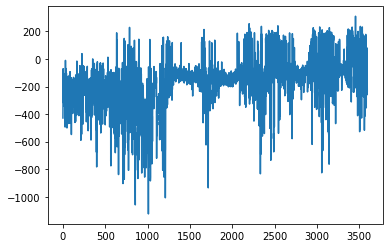

In [7]:
plt.plot(rewards_tracking)
plt.show()

## We can plot the loss curves below:

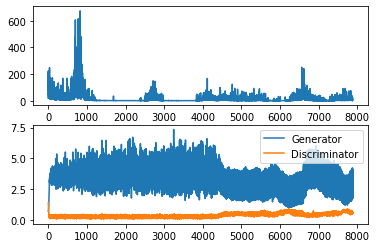

In [8]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(np.linspace(0, len(ddqn_losses), len(ddqn_losses)), ddqn_losses, label="DDQN Losses")
plt.subplot(2,1,2)
plt.plot(np.linspace(0, len(generator_losses), len(generator_losses)), generator_losses, label="Generator")
plt.plot(np.linspace(0, len(discriminator_losses), len(discriminator_losses)), discriminator_losses, label="Discriminator")
plt.legend()
plt.show()

## Testing
We can now run trajectories with the trained model, and calculate the errors

In [9]:
q_trained = q_est#torch.load("is_there_hope.pt", map_location="cpu") # or load a model here

In [10]:
import random
import matplotlib.pyplot as plt
from collections import deque

In [11]:
def flatten_deque(deque_to_flatten : deque) -> list:
    flattened = []
    for e in deque_to_flatten:
        flattened.extend(e)
    return flattened

In [13]:
observation = env.reset()
num_resets = 0
gamma = 0.99
id_ses = []
ood_ses = []
dists_from_end = []
weights_ratios = []
ood_weights_list = []
trajectory = Trajectory(gamma)
obs_list = deque([observation for i in range(small_obs_buffer)],small_obs_buffer)
for frame in range(10000):
    # Sample from environment!
    #env.render()
    obs_list.append(observation)
    torchy_obs = torch.FloatTensor(obs_list).unsqueeze(0)
    pred = q_trained(torchy_obs)
    max_val = pred[0].max()
    action = pred[0].argmax().numpy()
    if random.random() < 0.02:
        observation_p, reward, done, info = env.step(env.action_space.sample())
    else:
        observation_p, reward, done, info = env.step(action)
    trajectory.add(obs_list, action, flatten_deque(obs_list), reward, done, max_val)
    
    observation = observation_p
    if done:
        num_resets += 1
        labels = eric_gan.discriminator(torch.FloatTensor(trajectory.obs_p))
        id_weights = labels[:,0]
        ood_weights = labels[:,1]
        weights_ratios.append(float((ood_weights).sum() / trajectory.length))
        ood_weights_list.extend(ood_weights.detach().numpy())
        q_vals_t = torch.FloatTensor(trajectory.q_vals)
        cum_rewards_t = torch.FloatTensor(trajectory.cum_rewards)
        rewards_t = torch.FloatTensor(trajectory.rewards)
        se = (q_vals_t - cum_rewards_t).pow(2)
        ood_se = se * ood_weights
        id_se = se * id_weights
        dist_from_end = [i for i in range(trajectory.length, 0, -1)]
        dists_from_end.extend(dist_from_end)
        ood_ses.extend(ood_se)
        id_ses.extend(id_se)
        trajectory.clear()
        observation = env.reset()
print(num_resets)


12


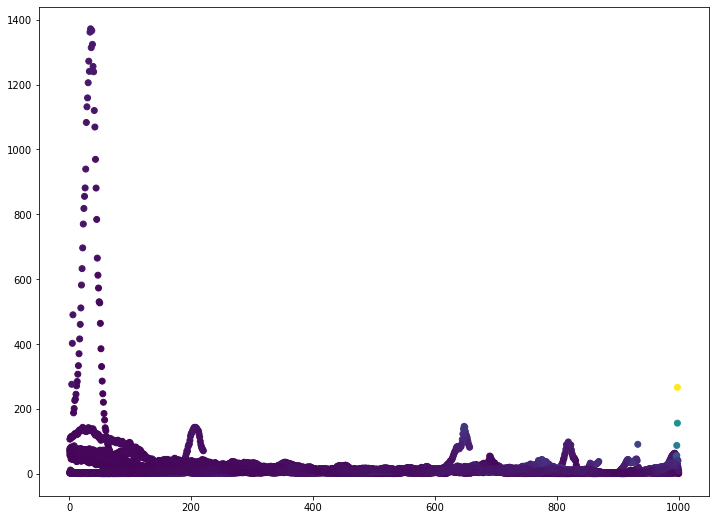

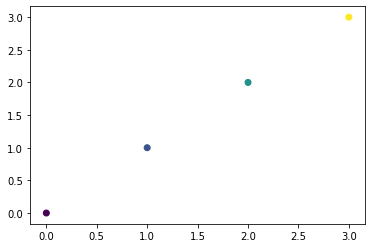

In [14]:
plt.figure(figsize=(12,9))

ood_weights_list_nums = [float(e) for e in ood_weights_list]
ood_ses_nums = [float(e) for e in ood_ses]
ses = [float(o + i) for o, i in zip(ood_ses, id_ses)]
plt.scatter(dists_from_end, ood_ses_nums, c=ood_weights_list_nums)
plt.show()
plt.scatter([0,1,2,3], [0,1,2,3], c=[0,0.2,0.4,0.8])

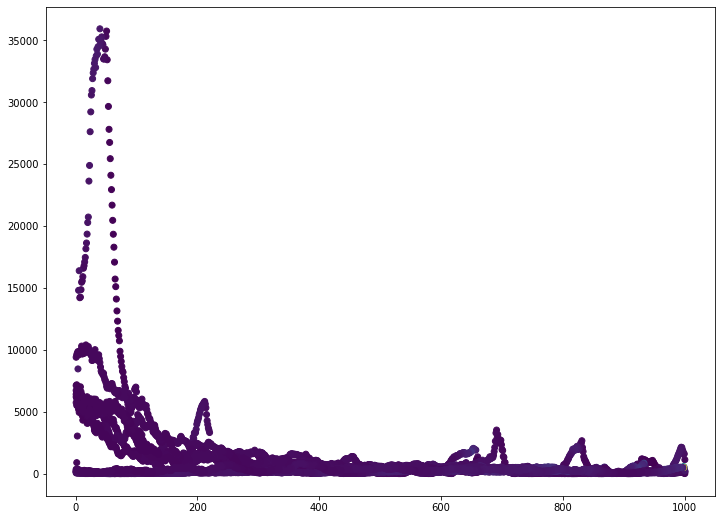

In [15]:
plt.figure(figsize=(12,9))
plt.scatter(dists_from_end, ses, c=ood_weights_list_nums)
plt.show()

In [19]:
print(ood_weights_list_nums[0:5])

[0.9135352969169617, 0.7192887663841248, 0.05085435509681702, 0.03131613880395889, 0.06235727667808533]


In [20]:
print(len(dists_from_end))

9870


## Visualize Results
This is where you can see how "weird" the graph results were. The first graph is the variance as a function of distance to end of trajectory, the second is separated into ood weighted error and id weighted error

In [72]:
print(len(ood_ses))
print()

38


In [87]:
np_ood_ses = [list(e) for e in ood_ses]
np_id_ses = [list(e) for e in id_ses]
np_ood_ses = np.array(np_ood_ses)
np_id_ses = np.array(np_id_ses)


TypeError: iteration over a 0-d tensor

In [32]:
print(np.array(weights_ratios).sum() / len(weights_ratios))

0.0320854185149


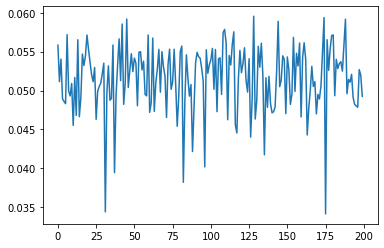

In [53]:
plt.plot(np.array(weights_ratios))

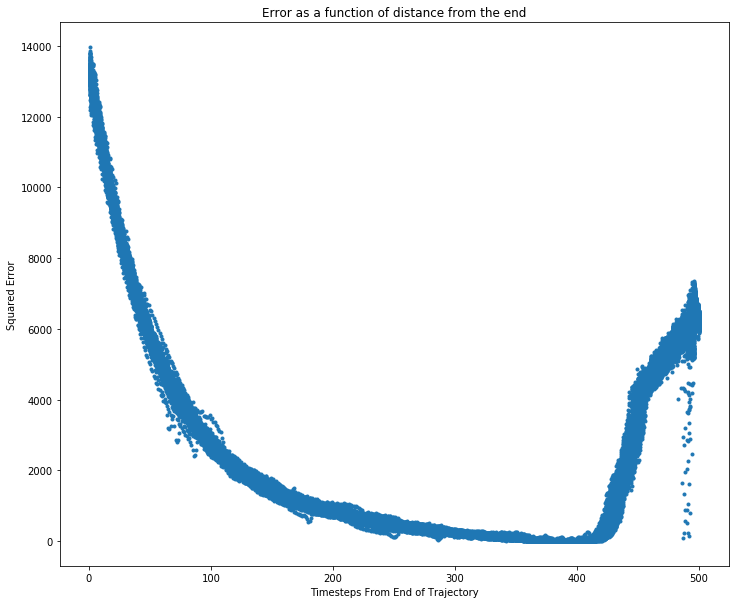

In [54]:
long_dists_list = []
[long_dists_list.extend(e) for e in dists_from_end]
long_se_list = []
[long_se_list.extend(o + i) for o, i in zip(ood_ses, id_ses)]
plt.figure(figsize=[12, 10])
plt.plot(long_dists_list, long_se_list, '.')
plt.title("Error as a function of distance from the end")
plt.xlabel("Timesteps From End of Trajectory")
plt.ylabel("Squared Error")
plt.show()

Squared error attributed to Generated:  tensor(4444295.5000, grad_fn=<AddBackward0>)


ValueError: 'c' argument has 100000 elements, which is not acceptable for use with 'x' with size 19000, 'y' with size 19000.

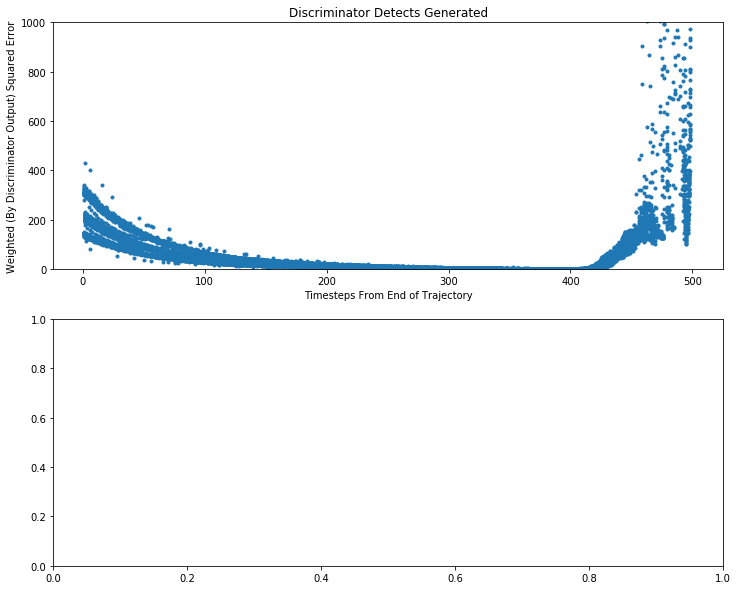

In [68]:
long_dists_list = []
[long_dists_list.extend(e) for e in dists_from_end]
long_se_list = []
[long_se_list.extend(o) for o in ood_ses]
plt.figure(figsize=[12, 10])
plt.subplot(2,1,1)
plt.plot(long_dists_list, long_se_list, '.')
plt.title("Discriminator Detects Generated")
plt.xlabel("Timesteps From End of Trajectory")
plt.ylim(0,1000)
plt.ylabel("Weighted (By Discriminator Output) Squared Error")
print("Squared error attributed to Generated: ", sum(long_se_list))

long_dists_list = []
[long_dists_list.extend(e) for e in dists_from_end]
long_se_list = []
[long_se_list.extend(i) for i in id_ses]
plt.subplot(2,1,2)
plt.scatter(long_dists_list, long_se_list_num, '.', c=ood_weights_list_nums)
plt.title("Discriminator Detects Real")
plt.xlabel("Timesteps From End of Trajectory")
plt.ylabel("Weighted (By Discriminator Output) Squared Error")
plt.show()

print("Squared error attributed to Real: ", (np.array(long_se_list)).sum())

In [67]:
long_se_list_num = [float(e) for e in long_se_list]
print(len(long_se_list_num))
print(len(long_dists_list))

19000
19000


I wrote this to give some background on what I have been doing for the past couple days. As a general theme, I wanted to see if we could use a GAN to detect when a model was going to make a high variance decision based on it's training data. I use the terms in domain and out of domain to mean both low variance and high variance decisions respectively and discriminator detects real data and discriminator detects generated data respectively.:
1. I ran an experiment on the inverse pendulum task to see if GANs could detect when something was out of domain. The experiment went as follows:

~~~~
Initialize gym environment
while not done training:
    take a random step
    record observation
    if environment says 'done' (when the pendulum swings beyond a certain angle) 
        reset environment
    if we have seen a new batch worth of data
        train GAN to generate observations and differentiate between observations and generated data
    
~~~~

Then, to test if the discriminator of the GAN could detect when something was out of domain, I ran the following code

~~~~
Initialize gym environment
while not done testing:
    take a random step
    record observation
    if environment says 'done' (when the pendulum swings beyond a certain angle) 
        record 40 more observations
        feed all observations into discriminator of GAN
        find ratio of observations after done classified as out of domain : total number of observations after done
        find ratio of observations before done classified as in domain : total number of observations before done
    
~~~~
What I found was that I could get a GAN to score above **.7** in both of these measures, which means a better than random chance at detecting out of domain, as defined by when the pendulum leaves an angle that has been seen before. When I trained the GAN on more iterations, I found that it didn't score quite as well, but I felt the concept was pretty well proven, and so it was worth finding a better way to solve for what "out of domain" and "in domain" are supposed to represent (in my mind), which is the variance of the model at certain states.

### DDQN Experiment
The next step was to find a way to measure the variance in outcome. To do this, I chose a Deep Q Network, because it literally makes predictions about what reward it is going to see. That means that if I can detect in or out of domain, I can directly measure the variance at each step. So, I implemented a DDQN, which seems to work well, though I have found that it trains slowly. This leads to possible action item 1 which is to **Implement prioritized experience replay**, my impression is that this will speed up training, which will be very nice. I also need to try running it on Restia, as I have just been running it locally. There also seems to be a bias in at least the lunar module predictions, so I don't know if I have trained long enough or there is a bug in the implementation, but the DDQN seems to at least find a reasonable solution to Lunar Module and Inverted Pendulum.

So, now that there is a way to measure variance from what the model expects for a given state, I trained the GAN and DDQN on the same data until the DDQN loss dropped to an acceptable? level. Then I ran 100,000 iterations of the DDQN making predictions and the discriminator determining to what degree the state was in or out of domain. I then calculated the square error between the q-values predicted by the GAN and the actualy discounted rewards of each trajectory. I then multiplied this error for each state by the "probability" the softmax of the discriminator assigned to the state as being in or out of domain.

I found that the average squared error for a state (the variance I think) that is in domain is consistently higher than the squared error for a state that is out of domain, at least as determined by the discriminator. After running those initial experiments, I thought to myself, this is happening because the initial states, which also likely have a pretty high variance as compared to end states (I thought to myself), will be more familiar to the discriminator, so it will say these states are in domain while later, more determined states are out of domain. So I wanted to find some way to control for this, so I came up with the plots you see. On the y-axis, the variance of the prediction. On the x-axis, the distance from the end of the trajectory. I think that this is a really really interesting graph, because you can see, the **the variance seems to increase EXPONENTIALLY as the end of the trajectory approaches (at least for the Lunar Lander simulation) for the situations we would want to detect, i.e. the times when the robot is about to jump off a cliff because it thinks there may be candy at the bottom**. Not only that, the scales of the graphs only continue to confirm what the variance calculation I was making earlier seemed to suggest, that the discriminator was detecting high variance to when an observation was detected to be real, and low variance when the data detected to be generated. However, I don't think you can just use these numbers, as there are also instances when the data is detected to be real, and it is low variance. Basically, this is not super 

### My Take
This is my take about what is going on. The Generator tries to mimic the distribution of the data, right? So, if the generator becomes good enough to match the domain well, the data we really want to look at is the data that *isn't possibly* from a well trained generator. This issue though is that we also train the discriminator to recognize the distribution the generator is training to mimic, so the discriminator predicts real data both in cases you well understand and see a lot, and also the cases that look very strange and probably have never seen before. Also note, the average "in domain" value is 0.85 ish and the average "out of domain" value is 0.15 ish, which makes sense given that I trained the network on 1500000 iterations of the lunar lander, so everything in the simulation should look reasonable familiar to the network :). 


So, with this is mind, I think that this approach is probably not appropriate for detecting cases that we shouldn't trust. I think there is some merit in GANs trained with a different approach, but I am interested in maybe exploring some other methods. One I think has some promise is looking at embeddings of observations and clustering them, maybe with a GMM, to find "weird observations", which is probably a better measure than generated or not, but we can talk about that.

In [27]:
torch.save(q_est, "is_there_hope.pt")

In [2]:
q_est = torch.load("is_there_hope.pt")

/anaconda3/envs/deeprlbootcamp/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'ddqn.Conv1dEstimator' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
